# Correcting absolute hydration free energies using support vector machines

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Path variables</a></span></li><li><span><a href="#Logger" data-toc-modified-id="Logger-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Logger</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Cross validation</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Hyper-parameter-ranges" data-toc-modified-id="Hyper-parameter-ranges-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Hyper-parameter ranges</a></span></li><li><span><a href="#SVR-model" data-toc-modified-id="SVR-model-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>SVR model</a></span></li><li><span><a href="#Training-function" data-toc-modified-id="Training-function-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Training function</a></span></li><li><span><a href="#Perform-training-per-fold" data-toc-modified-id="Perform-training-per-fold-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Perform training per fold</a></span></li></ul></li><li><span><a href="#Hyper-parameter-search-space" data-toc-modified-id="Hyper-parameter-search-space-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Hyper-parameter search space</a></span><ul class="toc-item"><li><span><a href="#Convergence-plot" data-toc-modified-id="Convergence-plot-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Convergence plot</a></span></li></ul></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Load-testing-data" data-toc-modified-id="Load-testing-data-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Load testing data</a></span><ul class="toc-item"><li><span><a href="#FreeSolve-database" data-toc-modified-id="FreeSolve-database-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>FreeSolve database</a></span></li><li><span><a href="#External-test-set" data-toc-modified-id="External-test-set-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>External test set</a></span><ul class="toc-item"><li><span><a href="#FreeSolve-format" data-toc-modified-id="FreeSolve-format-8.1.2.1"><span class="toc-item-num">8.1.2.1&nbsp;&nbsp;</span>FreeSolve format</a></span></li><li><span><a href="#Features-and-labels-format" data-toc-modified-id="Features-and-labels-format-8.1.2.2"><span class="toc-item-num">8.1.2.2&nbsp;&nbsp;</span>Features and labels format</a></span></li></ul></li></ul></li><li><span><a href="#Original-$\Delta-G_{hydr}$" data-toc-modified-id="Original-$\Delta-G_{hydr}$-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Original $\Delta G_{hydr}$</a></span></li><li><span><a href="#Predict-$\Delta-G_{offset}$" data-toc-modified-id="Predict-$\Delta-G_{offset}$-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Predict $\Delta G_{offset}$</a></span></li><li><span><a href="#$\Delta-G_{hydr}$-correction" data-toc-modified-id="$\Delta-G_{hydr}$-correction-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>$\Delta G_{hydr}$ correction</a></span></li></ul></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import scipy
import shutil
import logging
import pickle
import statistics
from tqdm import tqdm_notebook as tqdm

# SVM:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Global variables

In [2]:
# Global variables:
model_type = 'SVM'
kernel = 'poly'
label_col = 'dGoffset (kcal/mol)'

# set data processing configurations:
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
best_mae = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Random number seed

## Path variables

In [3]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
output_dr = path + 'output' + '_' + kernel + '/'
if not os.path.exists(output_dr):
    os.mkdir(output_dr)
figures_dr = path + 'figures' + '_' + kernel + '/'
if not os.path.exists(figures_dr):
    os.mkdir(figures_dr)
freesolv_loc = datasets_dr + 'freesolv_database.txt'

## Logger

In [4]:
# clean slate output_dr
if os.path.exists(output_dr):
    shutil.rmtree(output_dr)
if not os.path.exists(output_dr):
    os.mkdir(output_dr)

# initiate log file
logging.basicConfig(filename= output_dr + 'dGhydr_' + model_type + '.log',
                    filemode='a',
                    format='%(asctime)s - %(message)s',
                    level=logging.INFO)

logging.info('Starting {}.ipynb.'.format(os.path.abspath('')))
logging.info('\n\nParameters:\n\nn_calls = {}  # gp_minimize\nn_splits = {}  # Kfolds\n'.format(n_calls, n_splits))

## Data preparation

### Load data

In [5]:
train_df = pd.read_hdf(datasets_dr + 'train_data.h5', key='absolute')
train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,dGoffset (kcal/mol)
mobley_1017962,1.781592,-9.059647,3.780119,-1.056808,-1.528974,1.154161,2.361153,-2.700138,-5.169281,-2.558583,...,0.176910,0.448660,-0.481919,-0.730970,1.433422,-0.871800,-0.046023,0.146078,-0.985729,0.81
mobley_1019269,-15.261008,-4.347183,1.379246,0.645708,1.531135,0.856268,2.825631,1.283684,-3.142267,-1.366230,...,0.650525,-0.065040,-0.539433,0.367840,0.331124,0.003756,-0.432505,-0.340372,0.021577,-1.49
mobley_1034539,36.296153,18.307947,-16.146556,9.478137,5.356792,-1.551679,8.356573,-6.716154,-1.947512,7.365367,...,0.168824,0.777216,1.135480,0.712777,-0.498693,0.691487,-1.452439,0.096043,-1.621214,-1.96
mobley_1036761,-7.287637,-6.559314,-4.371576,-0.002275,1.794860,5.108000,0.532538,-1.465378,-2.029966,-1.791384,...,0.644729,0.141384,2.021007,0.251282,-0.186177,0.216360,-2.022736,-0.802692,-0.227339,-0.64
mobley_1046331,0.013096,5.160060,-0.553108,-8.828100,-1.271934,-2.744112,1.456818,0.573025,-3.004421,-1.923495,...,-0.823191,0.277780,1.177761,-0.455553,0.149812,-0.992073,-0.448685,-0.195229,0.616093,1.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_9913368,-20.236474,9.027594,-0.488696,6.984286,2.903779,-4.453868,1.557532,1.482581,-0.569213,-0.728069,...,0.662516,0.124512,-1.252097,0.093136,0.964358,1.117784,-0.596488,0.125104,-0.104126,-1.80
mobley_9942801,0.465744,-3.377600,-9.321441,-5.431455,0.795493,0.275491,-3.901344,-1.813911,3.214033,0.992900,...,0.550031,-0.060056,0.567654,0.528096,0.281406,-0.258472,0.607825,0.480860,-0.378041,-0.38
mobley_994483,-23.790773,3.251655,-1.631419,11.152238,3.508680,-7.857823,-2.714649,3.183763,0.001303,-1.865963,...,0.202422,-0.385468,0.059621,-1.176402,0.542244,0.026653,-1.198516,-0.103893,0.185989,-1.23
mobley_9974966,-7.485137,-8.419295,-3.439812,6.400467,-3.151041,3.133507,-4.384348,-3.678455,6.494977,6.819835,...,-0.746396,-0.626866,-1.084912,0.240855,-0.400569,-1.748269,-0.498583,-0.721052,-0.141620,-1.35


### Cross validation

In [6]:
def split_dataset(dataset, n_splits, random_state):
    """KFold implementation for pandas DataFrame.
    (https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold)"""
    logging.info('Performing {}-fold cross-validation...'.format(n_splits))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    kfolds = []
    global offset_col_name

    for train, validate in kf.split(dataset):
        training = dataset.iloc[train]
        train_labels = training[label_col]
        train_set = training.drop(label_col, axis=1)

        validating = dataset.iloc[validate]
        validate_labels = validating[label_col]
        validate_set = validating.drop(label_col, axis=1)

        kfolds.append(
            [[train_set, validate_set],
             [train_labels, validate_labels]]
        )

    with open(path + 'kfolds.json', "wb") as f:
        pickle.dump(kfolds, f)

    logging.info('Pickled kfolds nested list at {}kfolds.json.'.format(path))
    return kfolds

In [7]:
# call function
kfolds = split_dataset(train_df, n_splits, random_state)

## Training

In [8]:
# init training statistics logger
mae_logger = output_dr + model_type + '_statistics.csv'
with open(mae_logger, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['Fold', 'MAE (kcal/mol)', 'Parameters'])

### Hyper-parameter ranges

In [9]:
# set hyper-parameter ranges, append to list
dim_param_C = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_C")
dim_param_gamma = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_gamma")
dim_param_epsilon = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_epsilon")

# gp_minimize dimensions
dimensions = [dim_param_C, dim_param_gamma, dim_param_epsilon]

### SVR model

In [10]:
def create_model(param_gamma, param_C, param_epsilon):
    """Returns a SVR class instance."""
    
    return SVR(kernel=kernel,
               gamma=param_gamma,
               C=param_C,
               epsilon=param_epsilon,
               verbose=False)

### Training function

In [11]:
class tqdm_skopt(object):
    """tqdm implementation for skopt.gp_minimize"""
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [12]:
def train_model(fold, fold_num):
    """
    1. Unpack data.
    2. Define fitness function for guassian process optmisation.
    3. Decorate fitness with pre-defined hyper-parameter ranges.
    4. Return and pickle final gp_minimize object.
    """
    logging.info('Started training fold {}...'.format(str(fold_num)))

    # retrieve data sets and convert to numpy array
    train_X = fold[0][0].values
    validate_X = fold[0][1].values
    train_y = fold[1][0].values
    validate_y = fold[1][1].values
    
    # define function for gaussian process optimisation
    @use_named_args(dimensions=dimensions)
    def fitness(param_C, param_gamma, param_epsilon):
        """Function for gaussian process optmisation."""

        # create SVR model
        model = create_model(param_C, param_gamma, param_epsilon)

        # train model on training data
        model.fit(train_X, train_y)

        # validate model
        predicted_y = model.predict(validate_X)
        mae = mean_absolute_error(validate_y, predicted_y)

        # update statistics
        with open(output_dr + model_type + '_statistics.csv', 'a') as file:
            writer = csv.writer(file)
            writer.writerow([fold_num, mae, [param_gamma, param_gamma, param_epsilon]])

        # check if model improves
        global best_mae
        if mae < best_mae:
            # update new model accuracy.
            best_mae = mae
            # overwrite model if mae improves
            pkl_file = output_dr + 'fold_' + str(fold_num) + '_' + model_type + '_model.pickle'
            with open(pkl_file, 'wb') as file: pickle.dump(model, file)
            logging.info('Saved {}.'.format(pkl_file))

        # reset best MAE
        best_mae = np.inf
        
        return mae
    
    # starting parameters
    default_parameters = [1.0, 1.0, 1.0]
    # optimise hyper-parameters
    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',  # Expected Improvement.
                                n_calls=n_calls,
                                x0=default_parameters,
                                verbose=False,
                                callback=[tqdm_skopt(total=n_calls, desc='Fold {}'.format(fold_num))])

    # save skopt object and analyse in a separate script as
    logging.info('Saved {}fold_{}_gp_minimize_result.pickle.'.format(output_dr, fold_num))

    logging.info('Finished training fold {}: {}.'.format(str(fold_num), search_result.x))
    return search_result

### Perform training per fold

In [13]:
# call train_model save gp_minimize objects to lsit
gp_results = [train_model(fold, fold_num + 1) for fold_num, fold in enumerate(kfolds)]

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been eval

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been eval

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been eval

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been eval

## Hyper-parameter search space

### Convergence plot

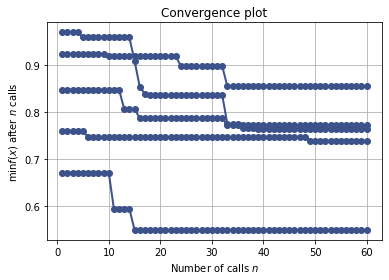

In [14]:
for result in gp_results:
    plot_convergence(result)

## External testing

In [15]:
def plot_scatter(x, y, title, x_label, y_label):
    """
    Returns and saves linear regression scatter plot.
    x: (list) calculated or predicted data.
    y: (list) true or experimental data.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # plot scatter
    plt.figure()
    plt.scatter(x, y, color='black', s=8)

    # plot line of best fit
    # https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
    plt.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=1)

    # axis labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # figure title
    plt.title(title)

    # absolute error
    ae = [abs(i - j) for i, j in zip(x, y)]
    # mean absolute error
    mae = statistics.mean(ae)
    
    # R-squared
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, x)
    r2 = r_value**2

    # annotate with r-squared and MAE
    string = 'R-squared = {}\nMAE = {}'.format(round(r2, 4), round(mae, 4))
    plt.annotate(string, xy=(0, 1),
                 xytext=(12, -12), va='top',
                 xycoords='axes fraction',
                 textcoords='offset points')

    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

### Load testing data

#### FreeSolve database

In [16]:
# load freesolv
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python', index_col='compound id (and file prefix)')
# index
fs_id = freesolv_df.index
# experimentally determined dGhydr
fs_exp = freesolv_df.iloc[:, 2].tolist()
# computationally calculated dGhydr
fs_calc = freesolv_df.iloc[:, 4].tolist()

#### External test set

##### FreeSolve format

In [17]:
# SAMPL4_Gurthrie df
test_fs_df = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie'].sort_index()
# SAMPL4_Gurthrie experimentally determined dGhydr
test_exp = test_fs_df.iloc[:, 2].tolist()
# SAMPL4_Gurthrie computationally calculated dGhydr
test_calc = test_fs_df.iloc[:, 4].tolist()

##### Features and labels format

In [18]:
# load external testing data
test_df = pd.read_hdf(datasets_dr + 'test_data.h5', key='absolute').sort_index()
# unpack testing set
test_id = test_df.index.tolist()
# features
test_X = test_df.drop(columns=label_col).values
# true computationally calculated labels
test_y = test_df[label_col].values

### Original $\Delta G_{hydr}$

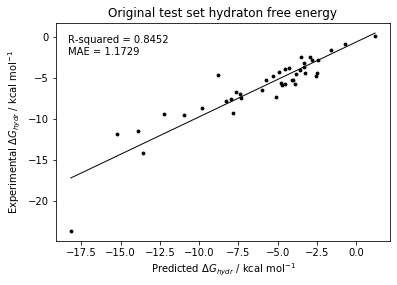

In [19]:
plot_scatter(x=test_calc,
             y=test_exp,
             title='Original test set hydraton free energy',
             x_label='Predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$')

### Predict $\Delta G_{offset}$

In [20]:
def model_predict(model_num, test_entry):
    """Load model from pickle and return model prediction on a given test_entry."""

    with open(output_dr + 'fold_' + str(model_num) + '_' + model_type + '_model.pickle', 'rb') as f:
        model = pickle.load(f)

    return model.predict(test_entry)

In [21]:
# ML predicted labels nested list per fold
predict_per_fold = [model_predict(fold_num, test_X) for fold_num in range(1, n_splits + 1)]
# average ML predicted labels
predict_y = np.average(predict_per_fold, axis=0)
# convert np array to float
predict_y = [float(x) for x in predict_y]

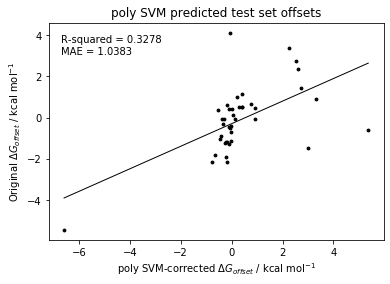

In [22]:
plot_scatter(x=predict_y,
             y=test_y,
             title=kernel + ' SVM predicted test set offsets',
             x_label=kernel + ' SVM-corrected $\Delta G_{offset}$ / kcal mol$^{-1}$',
             y_label='Original $\Delta G_{offset}$ / kcal mol$^{-1}$')

### $\Delta G_{hydr}$ correction

In [23]:
test_corr = [offset + calc for offset, calc in zip(predict_y, test_calc)]

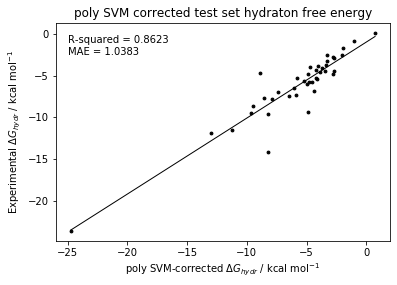

In [24]:
plot_scatter(x=test_corr,
             y=test_exp,
             title=kernel + ' SVM corrected test set hydraton free energy',
             x_label=kernel + ' SVM-corrected $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$')